In [1]:
# Import necessary libraries
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.utils.data as data
import numpy as np
from sklearn.metrics import accuracy_score
import os

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
# Data pre-processing and loading CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize CIFAR-10
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = data.DataLoader(trainset, batch_size=100, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = data.DataLoader(testset, batch_size=100, shuffle=False)


100%|██████████| 170M/170M [00:05<00:00, 33.7MB/s]


In [3]:
# Define the student model (ResNet8)
class ResNet8(nn.Module):
    def __init__(self):
        super(ResNet8, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((8, 8))  # Adjust spatial size to (8, 8)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)   # Input size of fc1 now 128*8*8
        self.fc2 = nn.Linear(256, 10)  # Output layer for 10 classes (CIFAR-10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)  # Apply adaptive pooling
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# Function to get predictions from a model
def get_predictions(model, dataloader):
    model.eval()  # Ensure evaluation mode
    all_preds = []
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
    return np.array(all_preds)

# Function to calculate agreement between teacher and student
def calculate_agreement(teacher_preds, student_preds):
    return np.mean(teacher_preds == student_preds)

In [5]:
# Load the pre-trained ResNet18 model (Teacher)
teacher_model = models.resnet18(pretrained=True)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 10)  # Modify the final layer for CIFAR-10
teacher_model = teacher_model.to(device)

# Fine-tune the teacher model
def fine_tune_teacher_model(model, trainloader, num_epochs=5):
    model.train()  # Set the model to training mode
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

        scheduler.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    # Save the fine-tuned teacher model
    torch.save(model.state_dict(), "fine_tuned_teacher_model.pth")
    print("Teacher model fine-tuned and saved.")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


In [6]:
# Fine-tune the teacher model
fine_tune_teacher_model(teacher_model, trainloader, num_epochs=5)

# Load the fine-tuned teacher model
teacher_model.load_state_dict(torch.load("fine_tuned_teacher_model.pth"))
teacher_model = teacher_model.to(device)

# Get predictions from the fine-tuned teacher model
teacher_preds = get_predictions(teacher_model, testloader)


Epoch [1/5], Loss: 0.9120, Accuracy: 69.21%
Epoch [2/5], Loss: 0.6015, Accuracy: 79.83%
Epoch [3/5], Loss: 0.4597, Accuracy: 84.43%
Epoch [4/5], Loss: 0.3717, Accuracy: 87.42%
Epoch [5/5], Loss: 0.2940, Accuracy: 90.09%
Teacher model fine-tuned and saved.


In [7]:
# Define and train the student model
student_model = ResNet8().to(device)
student_model.train()

# Loss function and optimizer for the student model
student_criterion = nn.CrossEntropyLoss()
student_optimizer = optim.Adam(student_model.parameters(), lr=0.001)
student_scheduler = lr_scheduler.StepLR(student_optimizer, step_size=7, gamma=0.1)

# Training the student model using teacher's outputs (pseudo-labels)
def train_student_model(model, teacher_model, trainloader, num_epochs=5):
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            student_optimizer.zero_grad()

            # Get teacher model's predictions (pseudo-labels)
            teacher_model.eval()
            with torch.no_grad():

                # TODO 1: 取得老師的輸出(logits)
                teacher_outputs = teacher_model(inputs)

                # TODO 2: 從 teacher_outputs 產生偽標（硬標籤 top-1）
                _, teacher_preds = torch.max(teacher_outputs, 1)

            # Forward pass using teacher's predictions (pseudo-labels)
            outputs = model(inputs)
            loss = student_criterion(outputs, teacher_preds)  # Use pseudo-labels

            # Backward pass and optimization
            loss.backward()
            student_optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == teacher_preds).sum().item()

            running_loss += loss.item()

        student_scheduler.step()
        print(f"Student Model - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    # Save the trained student model
    torch.save(model.state_dict(), "trained_student_model.pth")
    print("Student model trained and saved.")



In [8]:
# Train the student model with teacher's pseudo-labels
train_student_model(student_model, teacher_model, trainloader, num_epochs=5)

# Load the trained student model
student_model.load_state_dict(torch.load("trained_student_model.pth"))
student_model = student_model.to(device)

# Get predictions from the student model
student_preds = get_predictions(student_model, testloader)


Student Model - Epoch [1/5], Loss: 1.3263, Accuracy: 52.44%
Student Model - Epoch [2/5], Loss: 0.9314, Accuracy: 66.88%
Student Model - Epoch [3/5], Loss: 0.7554, Accuracy: 73.19%
Student Model - Epoch [4/5], Loss: 0.6311, Accuracy: 77.76%
Student Model - Epoch [5/5], Loss: 0.5123, Accuracy: 82.03%
Student model trained and saved.


## 作業最終提交之結果

In [9]:
# Calculate accuracy for both teacher and student models
teacher_accuracy = accuracy_score(testset.targets, teacher_preds) * 100
student_accuracy = accuracy_score(testset.targets, student_preds) * 100

# Calculate agreement between the teacher and student models
agreement = calculate_agreement(teacher_preds, student_preds)

# Print the results
print(f"Teacher Model Fine-tuned Accuracy: {teacher_accuracy:.2f}%")
print(f"Student Model Accuracy: {student_accuracy:.2f}%")
print(f"Agreement: {agreement * 100:.2f}%")


Teacher Model Fine-tuned Accuracy: 81.72%
Student Model Accuracy: 72.65%
Agreement: 73.90%


## 額外試試方法二...軟標籤(Softmax with temperature 𝑇)

In [10]:
# === Method 2: Soft Label Distillation (Fair Comparison) ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

# 建立新的 student 模型（不與硬標籤版本共用）
student_model_soft = ResNet8().to(device)
student_model_soft.train()

# === 與硬標籤版本相同的設定 ===
num_epochs = 5
T = 3.0
alpha = 0.5
student_optimizer = optim.Adam(student_model_soft.parameters(), lr=0.001)
student_scheduler = lr_scheduler.StepLR(student_optimizer, step_size=7, gamma=0.1)
criterion_CE = nn.CrossEntropyLoss()
criterion_KD = nn.KLDivLoss(reduction='batchmean')

def train_student_model_soft(model, teacher_model, trainloader, num_epochs=5, T=3.0, alpha=0.5):
    print(f"\n🧠 Training Student with Soft Label Distillation (T={T}, alpha={alpha}, epochs={num_epochs})\n")

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        model.train()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            student_optimizer.zero_grad()

            # === 老師模型輸出 ===
            teacher_model.eval()
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)

            # === 計算 soft targets ===
            soft_teacher_probs = F.softmax(teacher_outputs / T, dim=1)
            student_outputs = model(inputs)
            soft_student_log_probs = F.log_softmax(student_outputs / T, dim=1)

            # === 蒸餾損失 (soft labels) ===
            loss_KD = criterion_KD(soft_student_log_probs, soft_teacher_probs) * (T * T)
            # === 真實標籤損失 (hard labels) ===
            loss_CE = criterion_CE(student_outputs, labels)
            # === 混合總損失 ===
            loss = alpha * loss_KD + (1 - alpha) * loss_CE

            loss.backward()
            student_optimizer.step()

            # 計算準確率 (hard prediction)
            _, predicted = torch.max(student_outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        student_scheduler.step()
        acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss/len(trainloader):.4f}, Accuracy: {acc:.2f}%")

    # 儲存訓練後模型
    torch.save(model.state_dict(), "trained_student_model_soft.pth")
    print("\n✅ Student model (Soft Distillation) trained and saved.\n")

# === 開始訓練 ===
train_student_model_soft(student_model_soft, teacher_model, trainloader, num_epochs=num_epochs, T=T, alpha=alpha)


🧠 Training Student with Soft Label Distillation (T=3.0, alpha=0.5, epochs=5)

Epoch [1/5] - Loss: 2.8188, Accuracy: 51.01%
Epoch [2/5] - Loss: 1.8441, Accuracy: 65.05%
Epoch [3/5] - Loss: 1.4711, Accuracy: 71.42%
Epoch [4/5] - Loss: 1.2253, Accuracy: 76.02%
Epoch [5/5] - Loss: 1.0435, Accuracy: 79.74%

✅ Student model (Soft Distillation) trained and saved.



## 最終比較...

📊 Final Comparison of Knowledge Distillation Methods:



,Model,Accuracy (%),Agreement with Teacher (%)
0,Teacher,81.720000,—
1,Student (Hard Distillation),72.650000,73.900002
2,Student (Soft Distillation),73.750000,74.790001


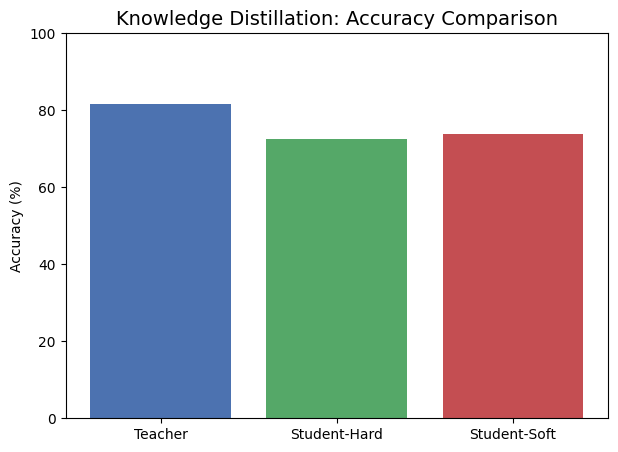

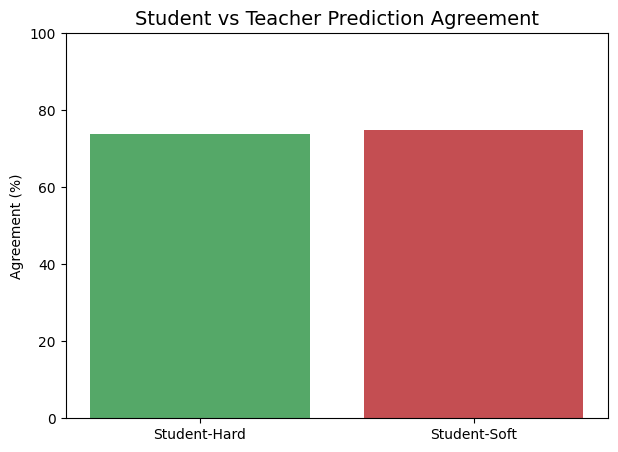

In [12]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

# === 定義評估函數 ===
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / total
    return accuracy, all_preds

# === 計算老師、學生模型表現 ===
teacher_acc, teacher_preds = evaluate(teacher_model, testloader)
student_acc_hard, student_preds_hard = evaluate(student_model, testloader)
student_acc_soft, student_preds_soft = evaluate(student_model_soft, testloader)

# === 一致率計算函數 ===
def calculate_agreement(preds1, preds2):
    preds1, preds2 = torch.tensor(preds1), torch.tensor(preds2)
    agreement = (preds1 == preds2).float().mean().item() * 100
    return agreement

agreement_hard = calculate_agreement(teacher_preds, student_preds_hard)
agreement_soft = calculate_agreement(teacher_preds, student_preds_soft)

# === 整理結果進 DataFrame ===
results_df = pd.DataFrame({
    "Model": ["Teacher", "Student (Hard Distillation)", "Student (Soft Distillation)"],
    "Accuracy (%)": [teacher_acc, student_acc_hard, student_acc_soft],
    "Agreement with Teacher (%)": ["—", agreement_hard, agreement_soft]
})

# === 顯示結果表格 ===
print("📊 Final Comparison of Knowledge Distillation Methods:\n")
display(results_df.style.set_table_styles([
    {"selector": "th", "props": [("background-color", "#1f77b4"), ("color", "white"), ("text-align", "center")]},
    {"selector": "td", "props": [("text-align", "center")]}
]).set_properties(**{"font-size": "13pt", "font-family": "Arial"}))

# === 視覺化條形圖 ===
plt.figure(figsize=(7,5))
plt.bar(["Teacher", "Student-Hard", "Student-Soft"],
        [teacher_acc, student_acc_hard, student_acc_soft],
        color=["#4C72B0", "#55A868", "#C44E52"])
plt.title("Knowledge Distillation: Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.show()

plt.figure(figsize=(7,5))
plt.bar(["Student-Hard", "Student-Soft"],
        [agreement_hard, agreement_soft],
        color=["#55A868", "#C44E52"])
plt.title("Student vs Teacher Prediction Agreement", fontsize=14)
plt.ylabel("Agreement (%)")
plt.ylim(0, 100)
plt.show()
